In [40]:
from typing import Tuple
from PIL import Image as imageMain
from PIL.Image import Image
import tempfile
import pdf2image
import cv2
import numpy
import matplotlib.pyplot as plt


In [ ]:
# This service contains all OpenCV / PIL / PDF functions that can be reused
class GraphicsService():
    def openImagePil(self, imagePath: str) -> Image:
        return imageMain.open(imagePath)

    def convertPilImageToCvImage(self, pilImage: Image):
        return cv2.cvtColor(numpy.array(pilImage), cv2.COLOR_RGB2BGR)

    def convertCvImagetToPilImage(self, cvImage) -> Image:
        return imageMain.fromarray(cv2.cvtColor(cvImage, cv2.COLOR_BGR2RGB))

    def openImageCv(self, imagePath: str):
        return self.convertPilImageToCvImage(self.openImagePil(imagePath))

    def cvToGrayScale(self, cvImage):
        return cv2.cvtColor(cvImage, cv2.COLOR_BGR2GRAY)

    def cvApplyGaussianBlur(self, cvImage, size: int):
        return cv2.GaussianBlur(cvImage, (size, size), 0)

    # Extracts all contours from the image, and resorts them by area (from largest to smallest)
    def cvExtractContours(self, cvImage):
        contours, hierarchy = cv2.findContours(cvImage, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        contours = sorted(contours, key = cv2.contourArea, reverse = True)
        return contours

    # Apply new color to the outer border of the image
    def paintOverBorder(self, cvImage, borderX: int, borderY: int, color: Tuple[int, int, int]):
        newImage = cvImage.copy()
        height, width, channels = newImage.shape
        for y in range(0, height):
            for x in range(0, width):
                if (y <= borderY) or (height - borderY <= y):
                    newImage[y, x] = color
                if (x <= borderX) or (width - borderX <= x):
                    newImage[y, x] = color
        return newImage

    # Rotate the image around its center
    def rotateImage(self, cvImage, angle: float):
        newImage = cvImage.copy()
        (h, w) = newImage.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        return newImage

    # Render one page of a PDF document to image
    def renderPdfDocumentPageToImageFromPath(self, pdfDocPath: str, pageNumber: int, dpi: int) -> str:
        tempFolder = tempfile.gettempdir()
        pageImagePaths = pdf2image.convert_from_path(pdfDocPath, dpi=dpi, output_folder=tempFolder, fmt='png', paths_only=True, thread_count=1, first_page=pageNumber, last_page=pageNumber)
        return pageImagePaths[0]

In [4]:

# This service contains core methods needed to deskew images
class DeskewService():
    # Calculate skew angle of an image
    def getSkewAngle(self, cvImage, debug: bool = False) -> float:
        # Prep image, copy, convert to gray scale, blur, and threshold
        newImage = cvImage.copy()
        gray = GraphicsService().cvToGrayScale(newImage)
        blur = GraphicsService().cvApplyGaussianBlur(gray, 9)
        thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
        if debug:
            cv2.imshow('Gray', gray)
            cv2.imshow('Blur', blur)
            cv2.imshow('Thresh', thresh)
            cv2.waitKey()

        # Apply dilate to merge text into meaningful lines/paragraphs.
        # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
        # But use smaller kernel on Y axis to separate between different blocks of text
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
        dilate = cv2.dilate(thresh, kernel, iterations=5)
        if debug:
            cv2.imshow('Dilate', dilate)
            cv2.waitKey()

        # Find all contours
        contours = GraphicsService().cvExtractContours(dilate)
        if debug:
            temp1 = cv2.drawContours(newImage.copy(), contours, -1, (255, 0, 0), 2)
            cv2.imshow('All Contours', temp1)
            cv2.waitKey()

        # Find largest contour and surround in min area box
        largestContour = contours[0]
        minAreaRect = cv2.minAreaRect(largestContour)
        if debug:
            minAreaRectContour = numpy.int0(cv2.boxPoints(minAreaRect))
            temp2 = cv2.drawContours(newImage.copy(), [minAreaRectContour], -1, (255, 0, 0), 2)
            cv2.imshow('Largest Contour', temp2)
            cv2.waitKey()

        # Determine the angle. Convert it to the value that was originally used to obtain skewed image
        angle = minAreaRect[-1]
        if angle < -45:
            angle = 90 + angle
        return -1.0 * angle

        # As your page gets more complex you might want to look into more advanced angle calculations
        #
        # Maybe use the average angle of all contours.
#         allContourAngles = [cv2.minAreaRect(c)[-1] for c in contours]
#         angle = sum(allContourAngles) / len(allContourAngles)
        #
        # Maybe take the angle of the middle contour.
#         middleContour = contours[len(contours) // 2]
#         angle = cv2.minAreaRect(middleContour)[-1]
        #
        # Maybe average angle between largest, smallest and middle contours.
#         largestContour = contours[0]
#         middleContour = contours[len(contours) // 2]
#         smallestContour = contours[-1]
#         angle = sum([cv2.minAreaRect(largestContour)[-1], cv2.minAreaRect(middleContour)[-1], cv2.minAreaRect(smallestContour)[-1]]) / 3
        #
        # Experiment and find out what works best for your case.

    # Deskew image
    def deskew(self, cvImage) -> Tuple:
        angle = self.getSkewAngle(cvImage)
        return GraphicsService().rotateImage(cvImage, -1.0 * angle), angle


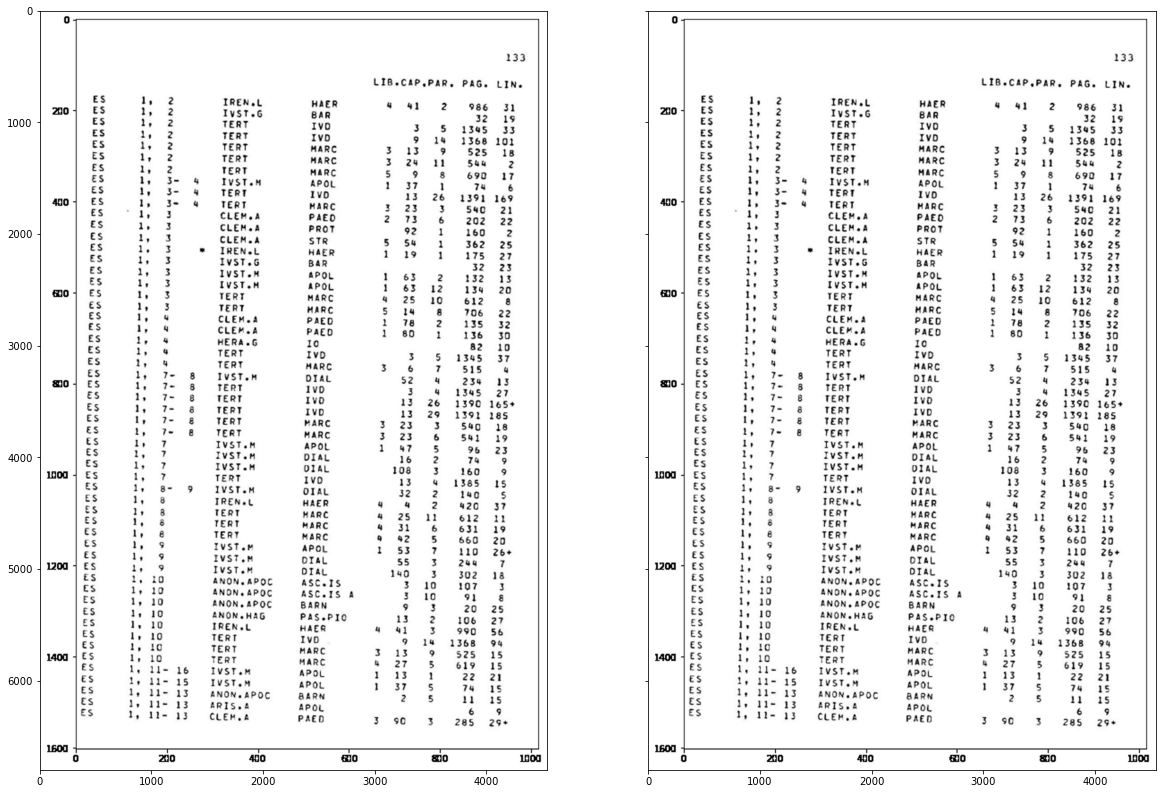

In [35]:
# testing on image
# only applicable for pdf documents not scanned old doc if quality is poor

images = ["right_page.png", "screen_short_low_qua.jpg", "screen_short_high_qua.png"]
imageCv = cv2.imread(images[0])#croped_images[13]

# if the image quality is poor then increase the image size
imageCv = cv2.resize(imageCv, None, fx=8, fy=8, interpolation=cv2.INTER_CUBIC)
# Deskew the image, and compare calculated skew angle to real one
deskewedImage, guessedAngle = DeskewService().deskew(imageCv)


fig = plt.figure(figsize=(20 , 15)) 
(ax1, ax2) = fig.subplots(1, 2, sharey='row')
ax1.imshow(imageCv)
ax2.imshow(deskewedImage)

## feature mapping

In [49]:
# stragiht bird's eye view image to get each line wise data not word enter data
left_page = imageCv
orb = cv2.ORB_create(1000)
kp1, des1 = orb.detectAndCompute(left_page, None)
impKp1 = cv2.drawKeypoints(left_page, kp1, None)

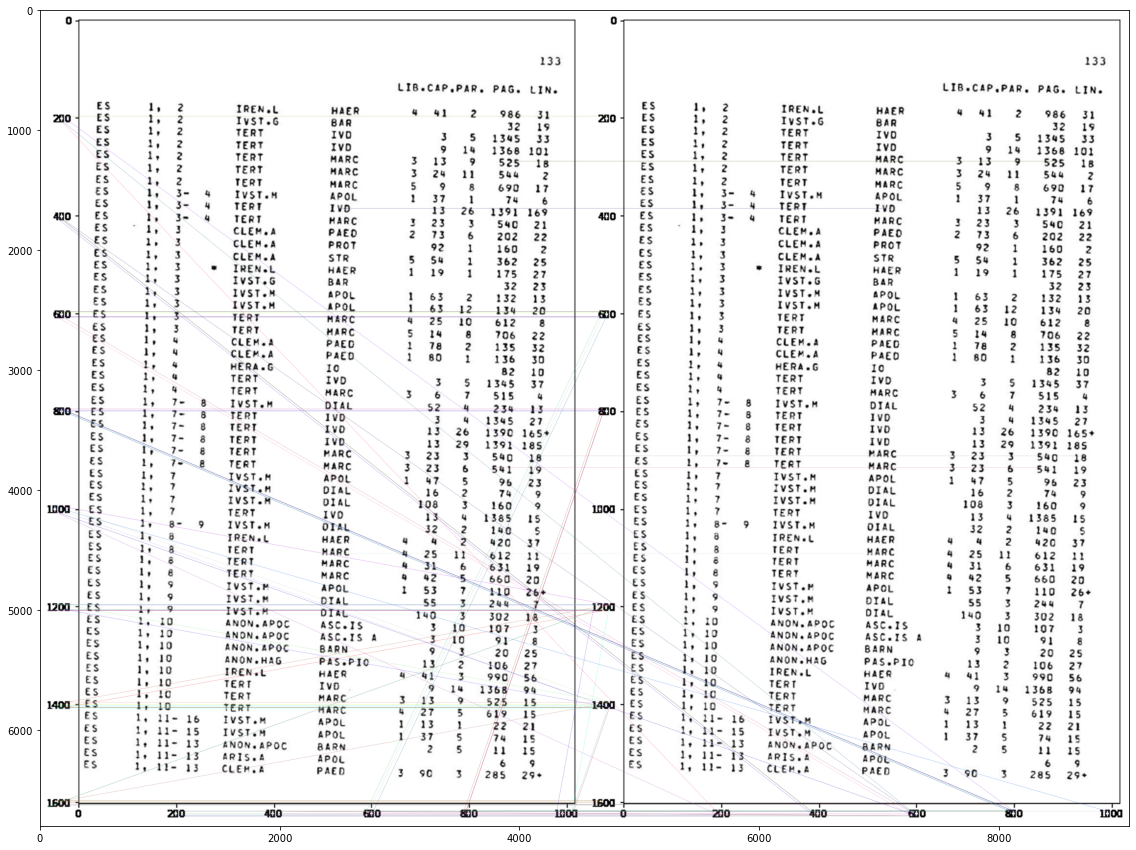

In [38]:
kp2, des2 = orb.detectAndCompute(left_page, None)
bf = cv2.BFMatcher(cv2.NORM_HAMMING)
matches = bf.match(des2, des1)
matches.sort(key=lambda x: x.distance)
good = matches[:int(len(matches)*(25/100))]
imgMatch = cv2.drawMatches(left_page, kp2, left_page, kp1, good[:100], None, flags=2)
plt.figure(figsize=(20 , 15)) 
plt.imshow(imgMatch)
# cv.imshow("left_page", imgMatch)
# quit()

In [47]:
scrPoints = numpy.float32([kp2[m.queryIdx].pt for m in good]).reshape(-1, 1,2)
dstPoints = numpy.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1,2)
M, _ = cv2.findHomography(scrPoints, dstPoints, cv2.RANSAC, 5.0)
imgScan = cv2.warpPerspective(left_page, M, (w, h))
# imgScan = cv.resize(imgScan, (w//3, h//3))# 

# birdseyeview image vs normal
fig = plt.figure(figsize=(20 , 15)) 
(ax1, ax2) = fig.subplots(1, 2, sharey='row')
ax1.imshow(left_page)
ax2.imshow(imgScan)

NameError: name 'w' is not defined